# Base model 

It is created by calculating average number of items sold per week for each product.
Model takes product_id and week for which to make a prediction as an input and returns prediction (average calculated from train set).

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle

plt.style.use('fivethirtyeight')
%matplotlib inline

In [40]:
save_plots = False
save_model = False

In [41]:
sessions = pd.read_json("../data/raw/second/sessions.jsonl", lines=True)
# bierzemy pod uwagę tylko te sesje, które zakończły się zakupem
buy_sessions = sessions[sessions['event_type'] == 'BUY_PRODUCT'].copy()
# data z timestampu w celu późniejszego grupowania
buy_sessions['date']=buy_sessions['timestamp'].dt.date
# te wartości i tak by znikły przy grupowaniu
buy_sessions.drop(columns=['user_id', 'event_type', 'offered_discount', 'session_id', 'timestamp'], inplace=True)
# grupujemy po dacie i ID produktu oraz dodajemy 0 dla produktów które nie były sprzedane danego dnia
df = buy_sessions.groupby(by=['date', 'product_id']).count().unstack(fill_value=0).stack().rename(columns={'purchase_id': 'amount'}).reset_index()
# nie ma to w sumie wielkiego znaczenia, ale lepiej żeby było to stringiem - ID nie musi być liczbą
df['product_id'] = df['product_id'].astype(str)

In [42]:
# co prawda przedtem robiliśmy w drugą stronę, ale teraz musimy to zamienić z powrotem na timestamp żeby pd.Grouper działało
df['date'] = pd.to_datetime(df['date'])
# grupujemy w tygodnie
df=df.groupby(by=[pd.Grouper(key='date', freq='W'), pd.Grouper(key='product_id')]).sum()

In [43]:
df.reset_index('product_id', inplace=True)

In [44]:
# tworzymy zbiór treningowy i testowy
split_date = pd.to_datetime('2021-09-01')
train = df.loc[df.index <= split_date].copy()
test = df.loc[df.index > split_date].copy()

In [45]:
import sys
sys.path.append('../')

In [46]:
from sales_forecasting.models.base_model import BaseModel
# tworzymy model
model = BaseModel(train)

In [47]:
assert model.predict('1002') == 2
assert model.predict('1006') == 1
assert model.predict('1314') == 0

In [48]:
test['amount_prediction'] = test['product_id'].apply(lambda x: model.predict(x))
test

,product_id,amount,amount_prediction
date,,,
2021-09-05,1002,0,2
2021-09-05,1003,0,2
2021-09-05,1004,0,2
2021-09-05,1005,0,2
2021-09-05,1006,0,1
...,...,...,...
2021-12-26,1310,0,0
2021-12-26,1311,0,0
2021-12-26,1312,0,0


In [49]:
test.shape[0]

3349

In [50]:
test

,product_id,amount,amount_prediction
date,,,
2021-09-05,1002,0,2
2021-09-05,1003,0,2
2021-09-05,1004,0,2
2021-09-05,1005,0,2
2021-09-05,1006,0,1
...,...,...,...
2021-12-26,1310,0,0
2021-12-26,1311,0,0
2021-12-26,1312,0,0


In [51]:
test['difference'] = test.apply(lambda x: x['amount'] - x['amount_prediction'], axis=1)
bias = test['difference'].mean()
print('bias:', bias)

bias: 0.11466109286354136


In [52]:
from sklearn.metrics import mean_squared_error as MSE
# traktujemy RMSE jako miernik jakości różnych wersji modelu
rmse=MSE(test['amount'], test['amount_prediction'],squared=False)
print('RMSE:', rmse)

RMSE: 2.6559454030299237


In [53]:
from sklearn.metrics import mean_absolute_error as MAE
mae = MAE(test['amount'], test['amount_prediction'])
print('MAE:', mae)

MAE: 0.8521946849805913


In [54]:
# # zwykły MAPE zwraca bardzo duże wartości, ponieważ niektóre wartości są zerami w test['amount']
# import numpy as np
# # SMAPE - Symmetrical Mean Absolute Percentage Error
# def SMAPE(act,forc):
#     return 100/len(act) * np.sum(2 * np.abs(forc - act) / (np.abs(act) + np.abs(forc)))

# smape = SMAPE(test['amount'], test['amount_prediction'])
# smape

In [55]:
if save_model:
    file_name = "base_model.pkl"

    # save
    pickle.dump(model, open(f"../models/{file_name}", "wb"))

    # load
    base_model_loaded = pickle.load(open(f"../models/{file_name}", "rb"))
    print(base_model_loaded)

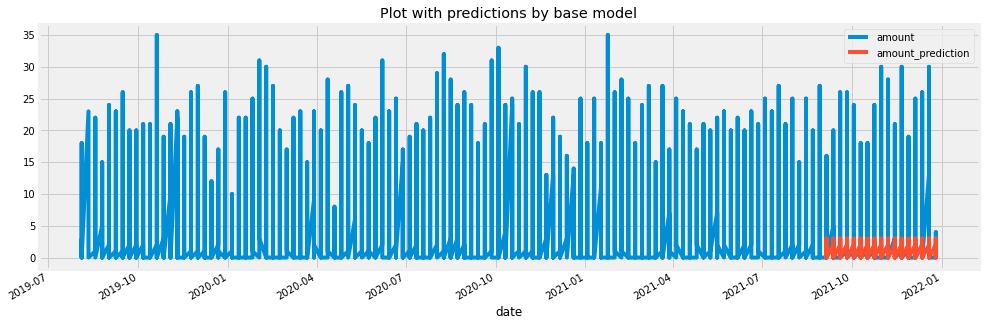

In [56]:
df_all = pd.concat([train, test], sort=False)
_ = df_all[['amount','amount_prediction']].plot(figsize=(15, 5), title='Plot with predictions by base model')
if save_plots:
    plt.savefig('base_model_plot.png')